In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from numba import double
from numba.decorators import jit

import sys
sys.path.append('../')

from sklearn.metrics import mean_squared_error


In [3]:
from src.plots import plot_map
from src.distances import euclidean_distance, get_gaussian_correlation_matrix
from src.synthetic_datasets import generate_gaussian_model, generate_dataset
from src.forward_problem import get_points, get_dist_matrix, get_observations
from src.inversion import get_m_linear


# Parameters

In [4]:
matplotlib.rcParams.update({'font.size': 15})

size_model = 30
size_data = 300

m_mean = 10
m_std = 2

# Build dataset

## Real model

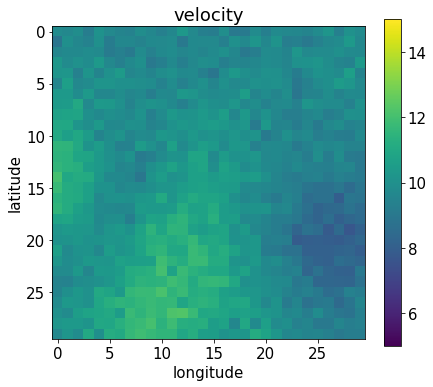

In [5]:
c = generate_gaussian_model(size_model, m_mean, m_std, seed=389)
plot_map(c, vmin=5, vmax=15, title='velocity')


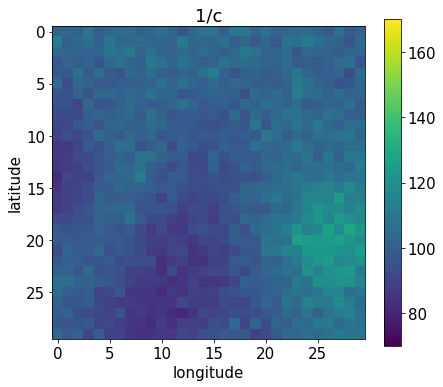

In [6]:
m = [[1/val*1e3 for val in row] for row in c]
plot_map(m, vmin=70, vmax=170, title='1/c')


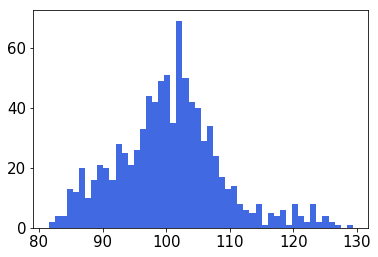

In [7]:
plt.hist(np.array(m).ravel(), bins=50, color='royalblue')
plt.show()

## Dataset
A data consist in the path between two points (p1, p2) = ((lat, lon), (lat,lon))

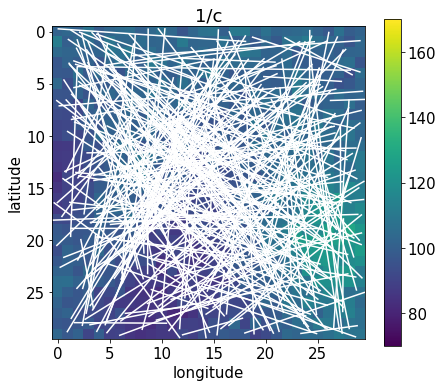

In [8]:
dataset = generate_dataset(size_data, size_model, min_lenght=3, seed=89)
plot_map(m, dataset, vmin=70, vmax=170, title='1/c')


## Get the time spent in each cell by a data

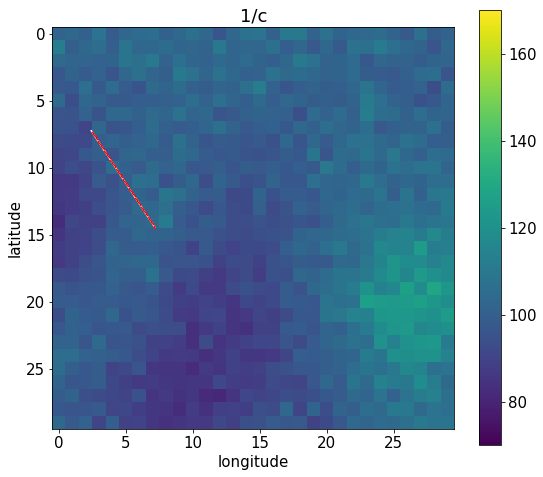

In [9]:
for data in dataset:
    plot_map(m, [data], get_points(data), vmin=70, vmax=170, figsize=(9,8), title='1/c')
    dist_matrix = get_dist_matrix(data, size=(size_model, size_model))
    break


## Build the synthetic dataset

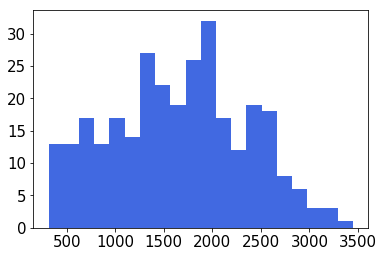

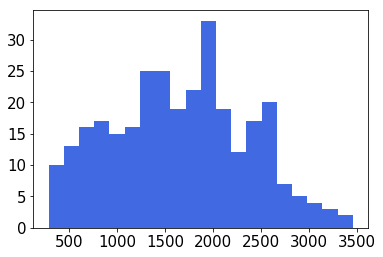

In [10]:
d0 = get_observations(dataset, m)

plt.hist(np.array(d0).ravel(), bins=20, color='royalblue')
plt.show()

d0 = get_observations(dataset, m, noise=25)

plt.hist(np.array(d0).ravel(), bins=20, color='royalblue')
plt.show()


# Setup of the matrices

In [11]:
m_0 = np.mean(np.divide(d0, np.array([euclidean_distance(data[0], data[1]) for data in dataset])))
sigma_m_0 = np.std(m)
sigma_d_0 = np.std(np.divide(d0, np.array([euclidean_distance(data[0], data[1]) for data in dataset])))
print(m_0, sigma_m_0, sigma_d_0)

parameters = {
    'm0': np.ones(size_model*size_model)*m_0,
    'C_m0': np.identity(size_model*size_model)*sigma_d_0**2,
    'd0': np.array(d0),
    'C_d0': np.identity(len(d0))*sigma_d_0**2,
    'G': np.array([get_dist_matrix(data, size=(size_model, size_model)).ravel() for data in dataset])
}

100.45284610845844 8.32078834202524 6.066775749196098


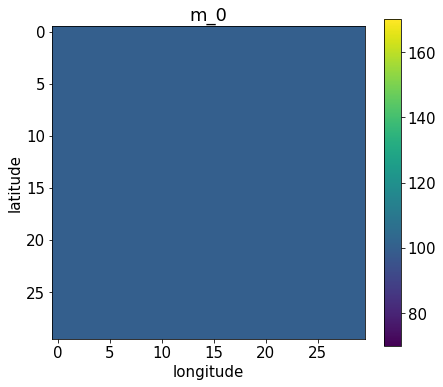

In [12]:
plot_map(parameters['m0'].reshape((size_model, size_model)), vmin=70, vmax=170, title='m_0')


# Solving

In [13]:
m_hat = get_m_linear(**parameters).reshape((size_model, size_model))


../src/inversion.py:19: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  return m0 + np.dot(np.dot(C_m0, np.transpose(G)), np.dot(np.linalg.inv(M), residuals))


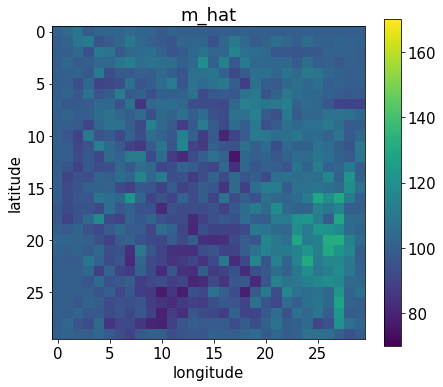

In [14]:
plot_map(m_hat, vmin=70, vmax=170, title='m_hat')


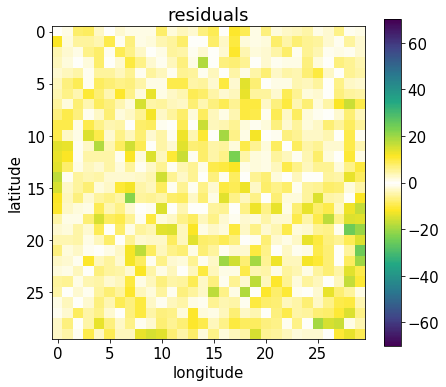

47.93618241913213
39.59854089406688


In [15]:
plot_map(m_hat - m, vmin=-70, vmax=70, title='residuals', cmap='viridis_residuals')
print(mean_squared_error(m_hat, m))

d_hat = get_observations(dataset, m_hat)
print(mean_squared_error(d_hat, np.array(d0)))


In [16]:
c_hat = [[1/val*1e3 for val in row] for row in m_hat]


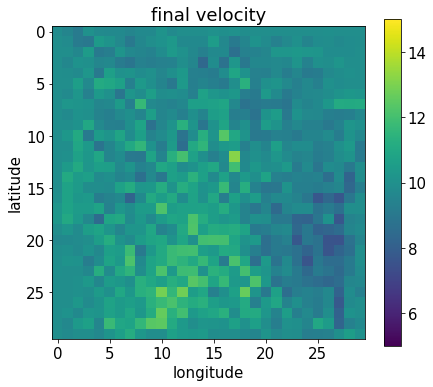

In [17]:
plot_map(c_hat, vmin=5, vmax=15, title='final velocity')


# New matrix

100.45284610845844 6.066775749196098 6.066775749196098 5


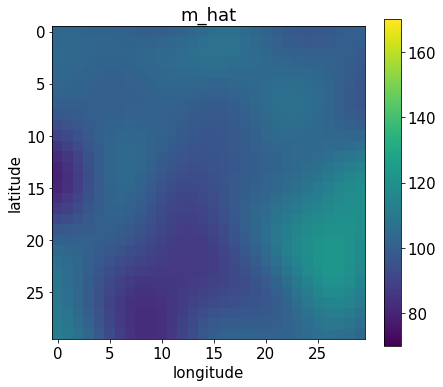

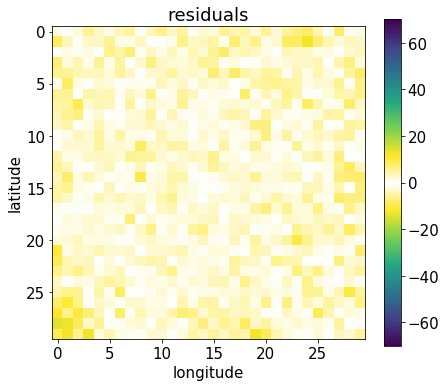

14.018317080825573
553.9253952838586


In [18]:
m_0 = np.mean(np.divide(d0, np.array([euclidean_distance(data[0], data[1]) for data in dataset])))
sigma_d_0 = np.std(np.divide(d0, np.array([euclidean_distance(data[0], data[1]) for data in dataset])))
sigma_m_0 = sigma_d_0
L = 5
print(m_0, sigma_m_0, sigma_d_0, L)

parameters = {
    'm0': np.ones(size_model*size_model)*m_0,
    'C_m0': get_gaussian_correlation_matrix(sigma=sigma_m_0, L=L, size_model=size_model),
    'd0': np.array(d0),
    'C_d0': np.identity(len(d0))*sigma_d_0**2,
    'G': np.array([get_dist_matrix(data, size=(size_model, size_model)).ravel() for data in dataset])
}

m_hat = get_m_linear(**parameters).reshape((size_model, size_model))
plot_map(m_hat, vmin=70, vmax=170, title='m_hat')
plot_map(m_hat - m, vmin=-70, vmax=70, title='residuals', cmap='viridis_residuals')
print(mean_squared_error(m_hat, m))
d_hat = get_observations(dataset, m_hat)
print(mean_squared_error(d_hat, np.array(d0)))


# Searching parameters

In [19]:
def get_score(m_0, sigma_m_0, sigma_d_0, L):
    parameters = {
        'm0': np.ones(size_model*size_model)*m_0,
        'C_m0': get_gaussian_correlation_matrix(sigma=sigma_m_0, L=L, size_model=size_model),
        'd0': np.array(d0),
        'C_d0': np.identity(len(d0))*sigma_d_0**2,
        'G': np.array([get_dist_matrix(data, size=(size_model, size_model)).ravel() for data in dataset])
    }

    m_hat = get_m_linear(**parameters).reshape((size_model, size_model))

    d_hat = get_observations(dataset, m_hat)

    return mean_squared_error(d_hat, np.array(d0))

m_0 = np.mean(np.divide(d0, np.array([euclidean_distance(data[0], data[1]) for data in dataset])))
sigma_d_0 = np.std(np.divide(d0, np.array([euclidean_distance(data[0], data[1]) for data in dataset])))

range_m_0 = 5
range_L = 5

result = []
list_sigma_m_0 = []
for i in range(range_m_0):
    sigma_m_0 = 10*i
    if sigma_m_0 == 0: sigma_m_0 = 1
    list_sigma_m_0.append(sigma_m_0)
    
    list_L = []
    for j in range(range_L):
        L = j + 1
        list_L.append(L)
        print(np.mean(m), sigma_m_0, sigma_d_0, L)
        result.append(get_score(np.mean(m), sigma_m_0, sigma_d_0, L))


100.54900402327094 1 6.066775749196098 1
100.54900402327094 1 6.066775749196098 2
100.54900402327094 1 6.066775749196098 3
100.54900402327094 1 6.066775749196098 4
100.54900402327094 1 6.066775749196098 5
100.54900402327094 10 6.066775749196098 1
100.54900402327094 10 6.066775749196098 2
100.54900402327094 10 6.066775749196098 3
100.54900402327094 10 6.066775749196098 4
100.54900402327094 10 6.066775749196098 5
100.54900402327094 20 6.066775749196098 1
100.54900402327094 20 6.066775749196098 2
100.54900402327094 20 6.066775749196098 3
100.54900402327094 20 6.066775749196098 4
100.54900402327094 20 6.066775749196098 5
100.54900402327094 30 6.066775749196098 1
100.54900402327094 30 6.066775749196098 2
100.54900402327094 30 6.066775749196098 3
100.54900402327094 30 6.066775749196098 4
100.54900402327094 30 6.066775749196098 5
100.54900402327094 40 6.066775749196098 1
100.54900402327094 40 6.066775749196098 2
100.54900402327094 40 6.066775749196098 3
100.54900402327094 40 6.066775749196098

In [20]:
result = np.array(result).reshape((range_m_0, range_L))

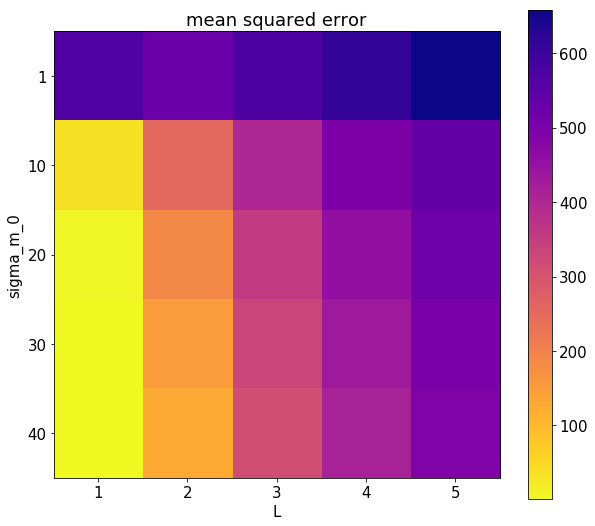

In [21]:
plt.figure(figsize=(10,9))
plt.imshow(result, aspect=range_L/range_m_0, cmap='plasma_r') 
plt.xlabel('L')
plt.ylabel('sigma_m_0')
plt.xticks(range(range_L), list_L)
plt.yticks(range(range_m_0), list_sigma_m_0)
plt.colorbar()
plt.title('mean squared error')
plt.show()

In [22]:
m_0 = np.mean(np.divide(d0, np.array([euclidean_distance(data[0], data[1]) for data in dataset])))
sigma_d_0 = np.std(np.divide(d0, np.array([euclidean_distance(data[0], data[1]) for data in dataset])))

arg_ok = np.argmin([np.min(r) for i, r in enumerate(result)])
sigma_m_0, L = [(list_sigma_m_0[i], list_L[np.argmin(r)]) for i, r in enumerate(result) if i == arg_ok][0]
print(m_0, sigma_m_0, sigma_d_0, L)


100.45284610845844 40 6.066775749196098 1


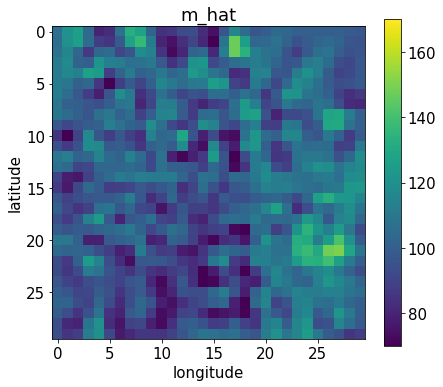

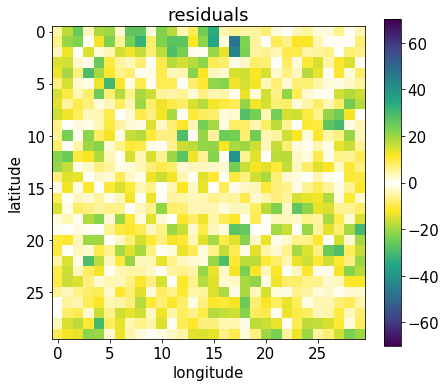

143.83452322015603


In [23]:
parameters = {
    'm0': np.ones(size_model*size_model)*m_0,
    'C_m0': get_gaussian_correlation_matrix(sigma=sigma_m_0, L=L, size_model=size_model),
    'd0': np.array(d0),
    'C_d0': np.identity(len(d0))*sigma_d_0**2,
    'G': np.array([get_dist_matrix(data, size=(size_model, size_model)).ravel() for data in dataset])
}

m_hat = get_m_linear(**parameters).reshape((size_model, size_model))

m_hat = get_m_linear(**parameters).reshape((size_model, size_model))
plot_map(m_hat, vmin=70, vmax=170, title='m_hat')
plot_map(m_hat - m, vmin=-70, vmax=70, title='residuals', cmap='viridis_residuals')
print(mean_squared_error(m_hat, m))
